In [ ]:
import os
import cv2
import numpy as np
import tensorflow as tf
from zipfile import ZipFile
from tqdm import tqdm
from sklearn.metrics import confusion_matrix, accuracy_score, f1_score, precision_score, recall_score, classification_report
from sklearn.model_selection import train_test_split
from sklearn import preprocessing
from keras.applications import vgg16
from keras.models import Model
from keras.layers import GlobalAveragePooling2D, Dense
import matplotlib.pyplot as plt
import seaborn as sns
from tensorflow.keras.models import Model
from tensorflow.keras.applications.vgg19 import preprocess_input
from tensorflow.keras.preprocessing import image
from PIL import Image
import numpy as np
import pandas as pd
from glob import glob
from keras.applications import VGG16
from keras.layers import Flatten, Dense, Dropout
from keras.models import Model
from keras import optimizers
from keras.callbacks import ModelCheckpoint
from keras.preprocessing.image import ImageDataGenerator
from datetime import datetime

In [ ]:
from google.colab import drive
drive.mount('/content/drive')


Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [ ]:
!unzip -o /content/drive/MyDrive/archive.zip -d /content/archive


Streaming output truncated to the last 5000 lines.
  inflating: /content/archive/Training/glioma/Tr-gl_0712.jpg  
  inflating: /content/archive/Training/glioma/Tr-gl_0713.jpg  
  inflating: /content/archive/Training/glioma/Tr-gl_0714.jpg  
  inflating: /content/archive/Training/glioma/Tr-gl_0715.jpg  
  inflating: /content/archive/Training/glioma/Tr-gl_0716.jpg  
  inflating: /content/archive/Training/glioma/Tr-gl_0717.jpg  
  inflating: /content/archive/Training/glioma/Tr-gl_0718.jpg  
  inflating: /content/archive/Training/glioma/Tr-gl_0719.jpg  
  inflating: /content/archive/Training/glioma/Tr-gl_0720.jpg  
  inflating: /content/archive/Training/glioma/Tr-gl_0721.jpg  
  inflating: /content/archive/Training/glioma/Tr-gl_0722.jpg  
  inflating: /content/archive/Training/glioma/Tr-gl_0723.jpg  
  inflating: /content/archive/Training/glioma/Tr-gl_0724.jpg  
  inflating: /content/archive/Training/glioma/Tr-gl_0725.jpg  
  inflating: /content/archive/Training/glioma/Tr-gl_0726.jpg  
  in

In [ ]:

train_path = '/content/archive/Training'
test_path = '/content/archive/Testing'

# Check if the paths exist
print("Checking paths...")
if os.path.exists(train_path):
    print(f"Training path exists: {train_path}")
else:
    print(f"Training path does not exist: {train_path}")

if os.path.exists(test_path):
    print(f"Testing path exists: {test_path}")
else:
    print(f"Testing path does not exist: {test_path}")

# Count the number of classes
num_classes = len(os.listdir(train_path))
print(f"Number of classes: {num_classes}")

Checking paths...
Training path exists: /content/archive/Training
Testing path exists: /content/archive/Testing
Number of classes: 4


In [ ]:
num_classes = len(os.listdir(train_path))
print(f"Number of classes: {num_classes}")
vgg = VGG16(input_shape=(224, 224, 3), weights='imagenet', include_top=False)


Number of classes: 4


In [ ]:
target_size = (224, 224)

In [ ]:
train_datagen = ImageDataGenerator(
    preprocessing_function=tf.keras.applications.vgg16.preprocess_input,
    rotation_range=30,
    width_shift_range=0.2,
    height_shift_range=0.2,
    shear_range=0.2,
    zoom_range=0.2,
    horizontal_flip=True,
    fill_mode='nearest'
)


In [ ]:
test_datagen = ImageDataGenerator(
    preprocessing_function=tf.keras.applications.vgg16.preprocess_input
)


In [ ]:
def get_file_paths_and_labels(base_path):
    file_paths = []
    labels = []
    class_names = os.listdir(base_path)
    for class_name in class_names:
        class_path = os.path.join(base_path, class_name)
        for file_name in os.listdir(class_path):
            file_paths.append(os.path.join(class_path, file_name))
            labels.append(class_name)
    return file_paths, labels

In [ ]:
train_file_paths, train_labels = get_file_paths_and_labels(train_path)
test_file_paths, test_labels = get_file_paths_and_labels(test_path)

In [ ]:
train_df = pd.DataFrame({'filename': train_file_paths, 'class': train_labels})
test_df = pd.DataFrame({'filename': test_file_paths, 'class': test_labels})


In [ ]:
train_set = train_datagen.flow_from_dataframe(
    train_df,
    x_col='filename',
    y_col='class',
    target_size=target_size,
    batch_size=32,
    class_mode='categorical'
)

val_set = test_datagen.flow_from_dataframe(
    test_df,
    x_col='filename',
    y_col='class',
    target_size=target_size,
    batch_size=32,
    class_mode='categorical'
)

Found 5712 validated image filenames belonging to 4 classes.
Found 1311 validated image filenames belonging to 4 classes.


In [ ]:
vgg = VGG16(input_shape=(224, 224, 3), weights='imagenet', include_top=False)


In [ ]:
for layer in vgg.layers[:-4]:
    layer.trainable = False

In [ ]:
x = GlobalAveragePooling2D()(vgg.output)
x = Dropout(0.5)(x)
x = Dense(1024, activation='relu')(x)
x = Dropout(0.5)(x)
prediction = Dense(num_classes, activation='softmax')(x)
model = Model(inputs=vgg.input, outputs=prediction)


In [ ]:
from tensorflow.keras.optimizers import Adam

adam = Adam(learning_rate=0.0001)
model.compile(loss='categorical_crossentropy', optimizer=adam, metrics=['accuracy'])

In [ ]:
checkpoint = ModelCheckpoint(filepath='best_model.h5', verbose=2, save_best_only=True)
callbacks = [checkpoint]

In [ ]:
start = datetime.now()


In [ ]:
model_history = model.fit(
    train_set,
    validation_data=val_set,
    epochs=20,
    steps_per_epoch=len(train_set),
    validation_steps=len(val_set),
    callbacks=callbacks,
    verbose=2
)


Epoch 1/20

Epoch 1: val_loss improved from inf to 0.61989, saving model to best_model.h5


/usr/local/lib/python3.10/dist-packages/keras/src/engine/training.py:3103: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


179/179 - 91s - loss: 0.9811 - accuracy: 0.5924 - val_loss: 0.6199 - val_accuracy: 0.7811 - 91s/epoch - 510ms/step
Epoch 2/20

Epoch 2: val_loss improved from 0.61989 to 0.46642, saving model to best_model.h5
179/179 - 89s - loss: 0.5313 - accuracy: 0.8081 - val_loss: 0.4664 - val_accuracy: 0.8284 - 89s/epoch - 495ms/step
Epoch 3/20

Epoch 3: val_loss improved from 0.46642 to 0.38391, saving model to best_model.h5
179/179 - 88s - loss: 0.3420 - accuracy: 0.8806 - val_loss: 0.3839 - val_accuracy: 0.8825 - 88s/epoch - 492ms/step
Epoch 4/20

Epoch 4: val_loss improved from 0.38391 to 0.34948, saving model to best_model.h5
179/179 - 88s - loss: 0.2543 - accuracy: 0.9140 - val_loss: 0.3495 - val_accuracy: 0.8894 - 88s/epoch - 490ms/step
Epoch 5/20

Epoch 5: val_loss improved from 0.34948 to 0.16286, saving model to best_model.h5
179/179 - 86s - loss: 0.2209 - accuracy: 0.9259 - val_loss: 0.1629 - val_accuracy: 0.9405 - 86s/epoch - 483ms/step
Epoch 6/20

Epoch 6: val_loss improved from 0.162

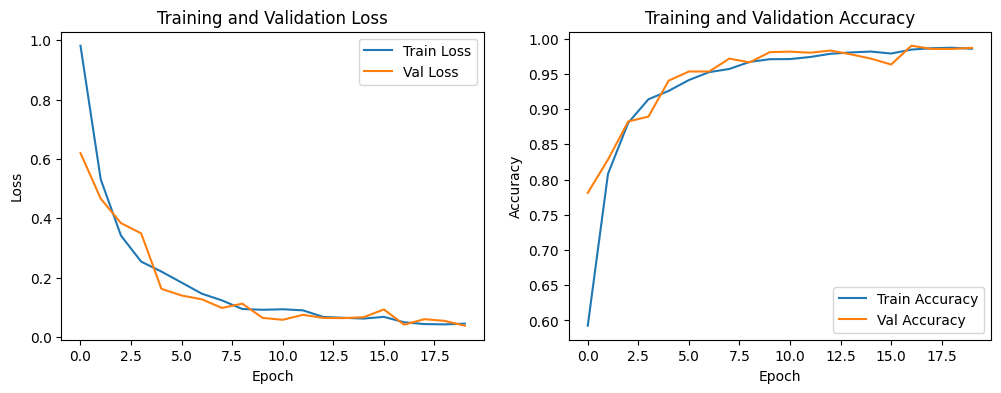

In [ ]:
plt.figure(figsize=(12, 4))

# Plot loss
plt.subplot(1, 2, 1)
plt.plot(model_history.history['loss'], label='Train Loss')
plt.plot(model_history.history['val_loss'], label='Val Loss')
plt.title('Training and Validation Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()
plt.savefig('LossVal_loss.png')

# Plot accuracy
plt.subplot(1, 2, 2)
plt.plot(model_history.history['accuracy'], label='Train Accuracy')
plt.plot(model_history.history['val_accuracy'], label='Val Accuracy')
plt.title('Training and Validation Accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.legend()
plt.savefig('AccVal_acc.png')
plt.show()

Found 1311 images belonging to 4 classes.
41/41 [==============================] - 7s 171ms/step
Accuracy: 0.8924485125858124
F1 Score: 0.8911838140213425
Precision: 0.9121721329666611
Recall: 0.8924485125858124
Classification Report:
              precision    recall  f1-score   support

      glioma       1.00      0.73      0.84       300
  meningioma       0.76      0.98      0.86       306
     notumor       0.89      1.00      0.94       405
   pituitary       1.00      0.82      0.90       300

    accuracy                           0.89      1311
   macro avg       0.91      0.88      0.89      1311
weighted avg       0.91      0.89      0.89      1311



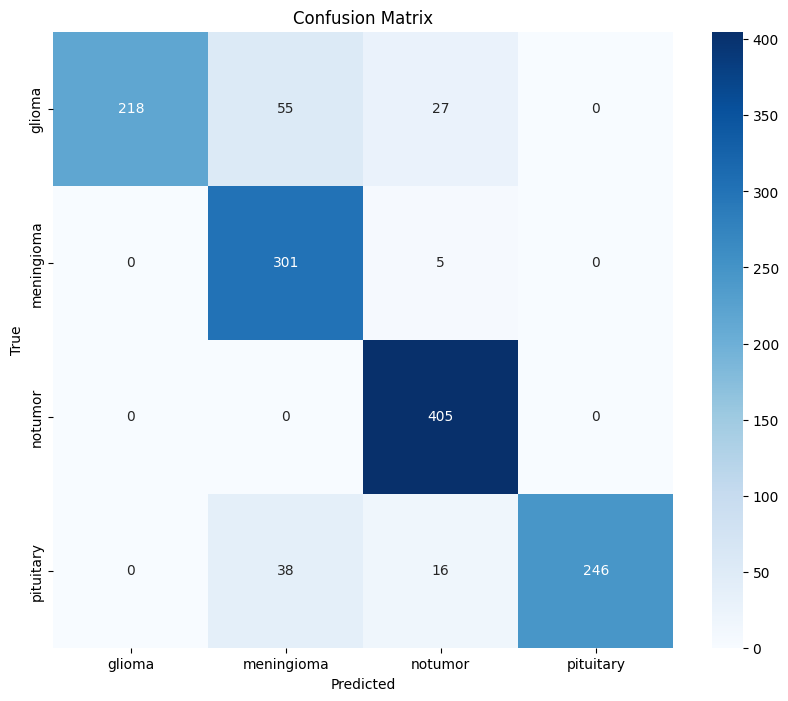

In [ ]:
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, classification_report, confusion_matrix
from keras.preprocessing import image
from keras.models import load_model

# Load the trained model
model = load_model('best_model.h5')

# Load the testing set
test_set = image.ImageDataGenerator().flow_from_directory('/content/archive/Testing', target_size=(224, 224), batch_size=32, class_mode='categorical', shuffle=False)

# Make predictions on the testing set
test_preds = model.predict(test_set)
test_preds_classes = np.argmax(test_preds, axis=1)
true_classes = test_set.classes

# Print metrics
accuracy = accuracy_score(true_classes, test_preds_classes)
precision = precision_score(true_classes, test_preds_classes, average='weighted')
recall = recall_score(true_classes, test_preds_classes, average='weighted')
f1 = f1_score(true_classes, test_preds_classes, average='weighted')

print(f"Accuracy: {accuracy}")
print(f"F1 Score: {f1}")
print(f"Precision: {precision}")
print(f"Recall: {recall}")

# Classification report
print("Classification Report:")
print(classification_report(true_classes, test_preds_classes, target_names=test_set.class_indices.keys()))

# Confusion matrix
conf_matrix = confusion_matrix(true_classes, test_preds_classes)
plt.figure(figsize=(10, 8))
sns.heatmap(conf_matrix, annot=True, fmt="d", cmap="Blues", xticklabels=test_set.class_indices.keys(), yticklabels=test_set.class_indices.keys())
plt.xlabel('Predicted')
plt.ylabel('True')
plt.title('Confusion Matrix')
plt.show()


In [ ]:
model.save('/content/drive/MyDrive/VGG-16')
